Age > 0 => Crimes on Humans  
Years Considered: 2023 only  
Crimes Considered: All types of Crimes

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [12]:
# Load the data
crimeData = pd.read_csv('LA Crime Data.csv')

In [13]:
# List of columns to drop
colsToRemove = [
    'DR_NO', 'Date Rptd', 'Rpt Dist No', 'Part 1-2', 'Mocodes', 
    'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 
    'Crm Cd 4', 'LOCATION', 'Cross Street', 'Weapon Used Cd', 'Weapon Desc',
    'Premis Cd', 'Premis Desc', 'LAT', 'LON'
]

crimeDataCleaned = crimeData.drop(columns=colsToRemove)

In [14]:
# Convert DATE OCC to datetime and extract Month and Year
crimeDataCleaned['DATE OCC'] = pd.to_datetime(crimeDataCleaned['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
crimeDataCleaned['Year'] = crimeDataCleaned['DATE OCC'].dt.year
crimeDataCleaned['Month'] = crimeDataCleaned['DATE OCC'].dt.month

In [15]:
crimeDataCleaned.describe()

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Year,Month
count,944235,944235.000000,944235.00000,944235.000000,944235.000000,944235.000000,944235.000000
mean,2022-03-22 01:21:52.136491776,1338.047956,10.72113,500.810848,29.499314,2021.744734,6.250125
min,2020-01-01 00:00:00,1.000000,1.00000,110.000000,-4.000000,2020.000000,1.000000
25%,2021-03-08 00:00:00,900.000000,6.00000,331.000000,0.000000,2021.000000,3.000000
50%,2022-04-09 00:00:00,1419.000000,11.00000,442.000000,30.000000,2022.000000,6.000000
75%,2023-04-10 00:00:00,1900.000000,16.00000,626.000000,45.000000,2023.000000,9.000000
max,2024-05-13 00:00:00,2359.000000,21.00000,956.000000,120.000000,2024.000000,12.000000
std,NaN,652.446103,6.09928,207.283501,21.882246,1.239839,3.490658


Fix TIME OCC

In [16]:
def correct_time_occ(time_occ):
    time_occ_str = str(time_occ)  # Convert to string for consistency
    length = len(time_occ_str)

    if length == 1:
        return f"0{time_occ_str}00"  # Single digit: prepend "0" and append "00"
    elif length == 2:
        return f"{time_occ_str}00"  # Two digits: append "00"
    elif length == 3:
        return f"0{time_occ_str}"  # Three digits: prepend "0"
    elif length == 4:
        return f"{time_occ_str}"  # Already in "HHMM" format, so return as is
    else:
        return time_occ_str  # Return as is for any other case

# Apply the function to correct TIME.OCC values
crimeDataCleaned['TIME OCC'] = crimeDataCleaned['TIME OCC'].apply(correct_time_occ)

# Extract the hour from the corrected TIME OCC values
crimeDataCleaned['hour'] = crimeDataCleaned['TIME OCC'].str[:2].astype(int)

In [17]:
# Filter out rows where Year is 2024
crimeDataCleaned = crimeDataCleaned[crimeDataCleaned['Year'] != 2024]

In [18]:
# Filter out rows where hour is greater than 23
crimeDataCleaned = crimeDataCleaned[crimeDataCleaned['hour'] <= 23]

In [19]:
# To ensure all columns have the right type assigned to it.

# Convert categorical columns to 'category' dtype
crimeDataCleaned['AREA'] = crimeDataCleaned['AREA'].astype('category')
crimeDataCleaned['Crm Cd'] = crimeDataCleaned['Crm Cd'].astype('category')
crimeDataCleaned['Vict Sex'] = crimeDataCleaned['Vict Sex'].astype('category')

# Convert numerical columns to 'float' or 'int' dtype if needed
crimeDataCleaned['Vict Age'] = crimeDataCleaned['Vict Age'].astype('int')  # if age can have decimal values; use int if only whole numbers
# crimeDataCleaned['LAT'] = crimeDataCleaned['LAT'].astype('float')
# crimeDataCleaned['LON'] = crimeDataCleaned['LON'].astype('float')
crimeDataCleaned['Year'] = crimeDataCleaned['Year'].astype('int')
crimeDataCleaned['Month'] = crimeDataCleaned['Month'].astype('int')
crimeDataCleaned['hour'] = crimeDataCleaned['hour'].astype('int')

# Display the data types to confirm the changes
print(crimeDataCleaned.dtypes)

DATE OCC        datetime64[ns]
TIME OCC                object
AREA                  category
AREA NAME               object
Crm Cd                category
Crm Cd Desc             object
Vict Age                 int64
Vict Sex              category
Vict Descent            object
Year                     int64
Month                    int64
hour                     int64
dtype: object


In [20]:
# This is where we filter out specific data to feed the model
# Filter data to only include records where Vict Age > 0
filtered_data = crimeDataCleaned[crimeDataCleaned['Vict Age'] > 0].copy()
#Considering data only for the year 2023
filtered_data = filtered_data[filtered_data['Year'] == 2023]

In [21]:
# Drop unnecessary columns
filtered_data = filtered_data.drop(columns=['DATE OCC', 'TIME OCC', 'AREA NAME', 'Crm Cd Desc', 'Year'])

In [22]:
# One-hot encode categorical columns
filtered_data = pd.get_dummies(filtered_data, columns=['AREA', 'Vict Sex', 'Vict Descent'], drop_first=True)

In [23]:
# Split the data into features (X) and target (y)
X = filtered_data.drop(columns=['Crm Cd'])
y = filtered_data['Crm Cd']

In [24]:
# Convert features to float32
X = X.astype('float32')

In [25]:
# One-hot encoding the target for neural networks
y_one_hot = to_categorical(y)

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_nn, y_test_nn = train_test_split(y_one_hot, test_size=0.2, random_state=42)

In [27]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2%}")

Random Forest Accuracy: 13.32%


In [28]:
# Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_nn.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the neural network
history = model.fit(X_train, y_train_nn, epochs=50, validation_data=(X_test, y_test_nn), batch_size=128)

# Evaluate the neural network
nn_loss, nn_accuracy = model.evaluate(X_test, y_test_nn)
print(f"Neural Network Accuracy: {nn_accuracy:.2%}")

Epoch 1/50
1036/1036 [==============================] - 19s 15ms/step - loss: 3.2968 - accuracy: 0.1297 - val_loss: 3.1336 - val_accuracy: 0.1605
Epoch 2/50
1036/1036 [==============================] - 14s 14ms/step - loss: 3.0836 - accuracy: 0.1680 - val_loss: 3.0594 - val_accuracy: 0.1733
Epoch 3/50
1036/1036 [==============================] - 15s 14ms/step - loss: 3.0426 - accuracy: 0.1763 - val_loss: 3.0428 - val_accuracy: 0.1750
Epoch 4/50
1036/1036 [==============================] - 14s 14ms/step - loss: 3.0251 - accuracy: 0.1785 - val_loss: 3.0331 - val_accuracy: 0.1790
Epoch 5/50
1036/1036 [==============================] - 12s 12ms/step - loss: 3.0124 - accuracy: 0.1816 - val_loss: 3.0207 - val_accuracy: 0.1781
Epoch 6/50
1036/1036 [==============================] - 14s 13ms/step - loss: 3.0047 - accuracy: 0.1827 - val_loss: 3.0225 - val_accuracy: 0.1786
Epoch 7/50
1036/1036 [==============================] - 12s 12ms/step - loss: 2.9964 - accuracy: 0.1851 - val_loss: 3.0089 -

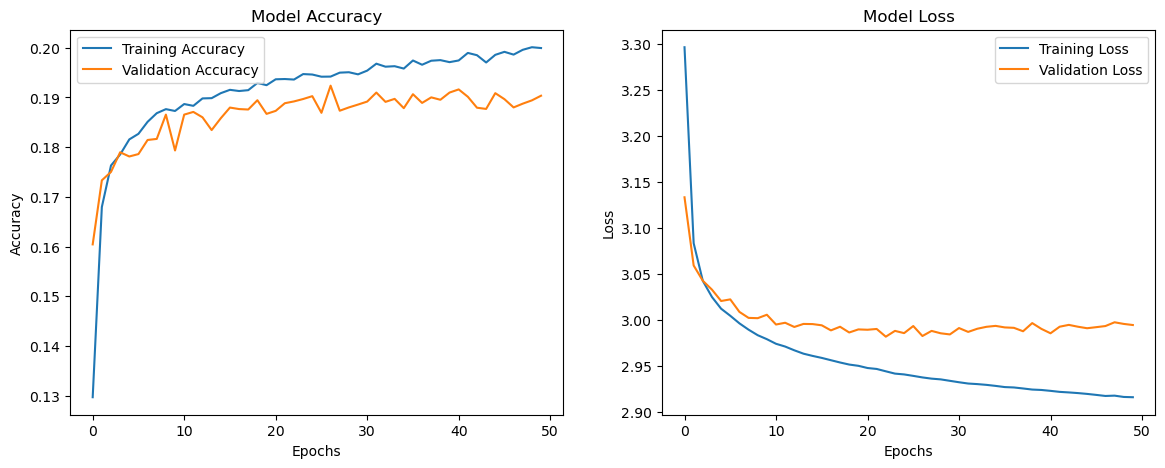

In [29]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search or Randomized Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=None, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2%}")

# Evaluate on the test set
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy:.2%}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/adithya/.conda/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  19.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  19.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  22.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim

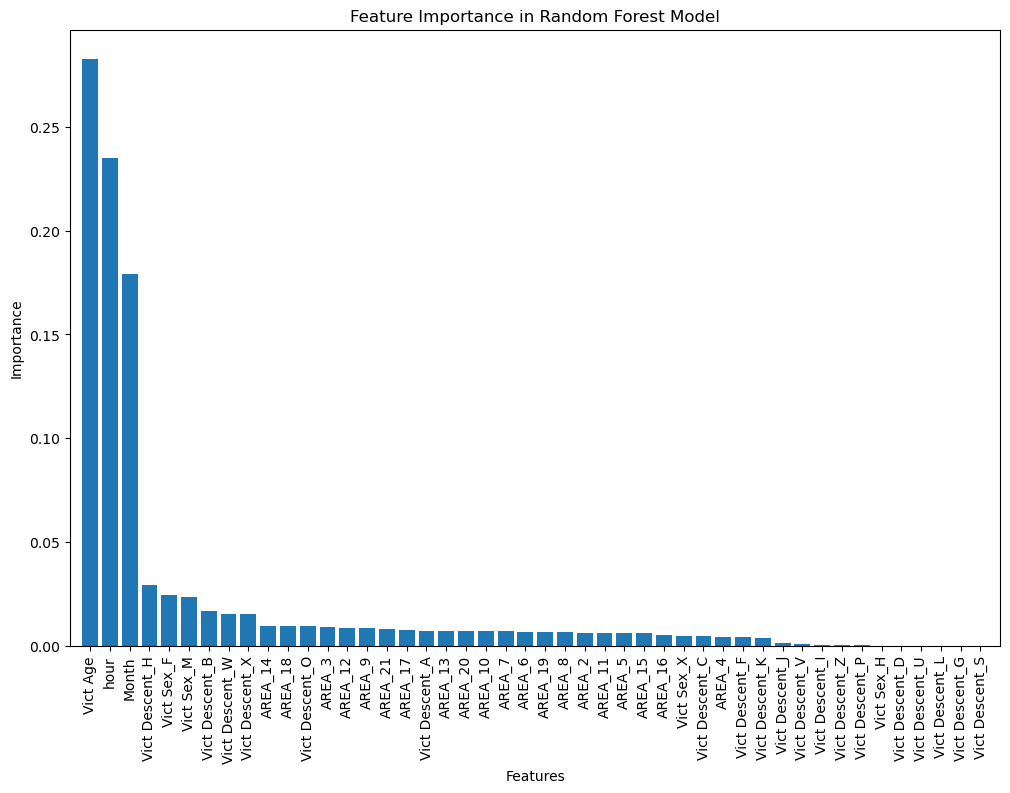

In [32]:
# Get feature importances from the model
feature_importances = best_rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# # Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importance in Random Forest Model")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()